In [319]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
from HelperFunctions import fnCDOregrid
from importlib import reload
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil

functions

In [320]:
level_s = np.array([0, 1, 2.5, 5, 7.5, 10, 15, 20,25, 37.5, 50,
         75, 100, 125, 150, 200, 250, 300, 400, 500, 600, 750])

proj = ccrs.PlateCarree()


def ax_coastlines_country(ax_s):
    ax_s.coastlines(linewidths=0.5)
    ax_s.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='10m',
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.2))

# plot_prec_4
def plot_prec_4(prec, min_v, max_v, cmap_s, colorbar_ori, is_prec):
    # is_prec: use precipitation contour interval
    #fig = plt.figure(figsize=(8,10), dpi=96)
   
    if is_prec=='True':
        ind_max = np.where(level_s==max_v)
        ind_i = int(ind_max[0])
        cnlevel = level_s[:ind_i+1]
    else:
        cnlevel = np.linspace(min_v, max_v, num=11)
  
    for col in range(4):
        ax_s = plt.subplot(2, 2, col+1, projection=proj)
        ax_coastlines_country(ax_s)
        ax_s.add_feature(cfeature.STATES, linestyle=':')
        mem = col + 1

        im=prec[col].plot.contourf(
            levels=cnlevel,
            cmap=cmap_s,
            ax=ax_s,
            transform=proj,
            add_colorbar=False)

        #if is_prec=='True':
            # use np.datetime_as_string to convert numpy.datetime64 to string obj
        plt.title(np.datetime_as_string(prec.coords['time'].values[col], unit='D'),fontweight="bold", size=15)
        #else:
        #    plt.title(prec.coords['day'][col], unit='D'),fontweight="bold", size=15)     
         
    plt.tight_layout()
    # The position of the bottom edge of the subplots, as a fraction of the figure height.
    #fig.subplots_adjust(bottom=0.15)

    #rect [left, bottom, width, height]
    #cbar_ax = fig.add_axes([0.2, 0.1, 0.7, 0.03])
    #fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
    if colorbar_ori=="vertical":
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.98, 0.1, 0.04, 0.8])
    else:
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.2, 0.001, 0.7, 0.03])
    
    fig.colorbar(im, cax=cbar_ax, orientation=colorbar_ori)

Parameters

In [338]:
### Boundrary
date_s = '2021-02-11'
date_e = '2021-02-14'
lat_s = 34.
lat_e = 48.
lon_s = -125.
lon_e = -115.

#### Prism Precipitation

/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/PRISM_daily_ppt_2021.nc


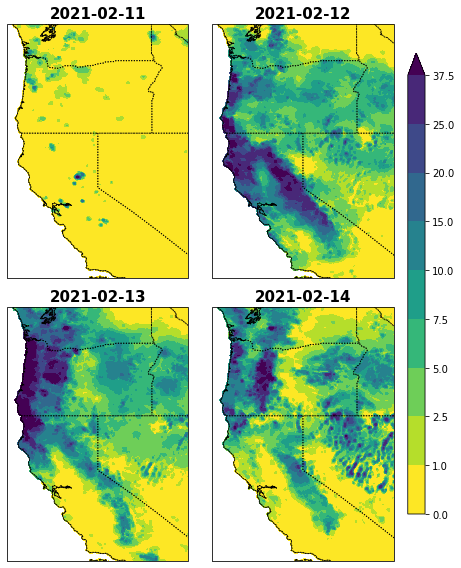

In [339]:
flnm_prism = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/PRISM_daily_ppt_2021.nc'
with xr.open_dataset(flnm_prism ) as ds_prism:
  print(flnm_prism)

##### select a range of dates using slice()
prec_t = ds_prism.PR.sel(time=slice(date_s, date_e),
                         rlat=slice(lat_e, lat_s), rlon=slice(lon_s, lon_e))

fig = plt.figure(figsize=(6,8))
plot_prec_4(prec_t, 1, 37.5,  'viridis_r', 'vertical', 'True') ## 'YlGnBu') 

#### PRISM Tmax

/glade/campaign/mmm/c3we/prein/observations/PRISM/data/Tmax/PRISM_daily_tmax_2021.nc


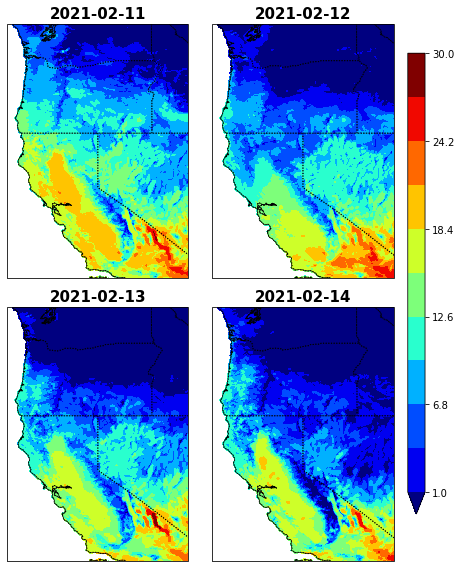

In [340]:
flnm_prism_tmax = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/Tmax/PRISM_daily_tmax_2021.nc'

with xr.open_dataset(flnm_prism_tmax ) as ds_prism_tmax:
  print(flnm_prism_tmax)

tmax_t = ds_prism_tmax.Tmax.sel(time=slice(date_s, date_e),
                         rlat=slice(lat_e, lat_s), rlon=slice(lon_s, lon_e))

fig = plt.figure(figsize=(6,8))
plot_prec_4(tmax_t, 1, 30,  'jet', 'vertical', 'False') ## 'YlGnBu') 

#### PRISM Tmin

/glade/campaign/mmm/c3we/prein/observations/PRISM/data/Tmin/PRISM_daily_tmin_2021.nc


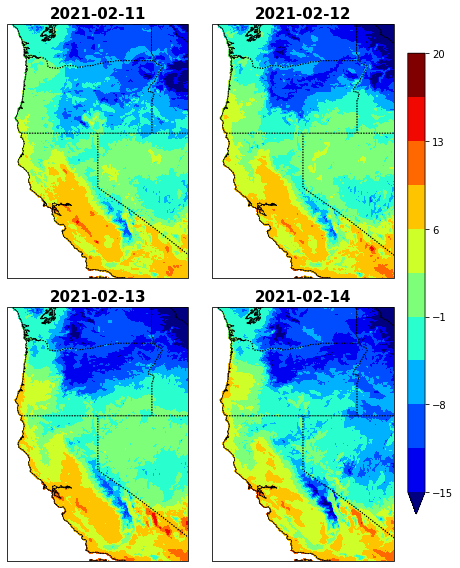

In [341]:
flnm_prism_tmin = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/Tmin/PRISM_daily_tmin_2021.nc'
with xr.open_dataset(flnm_prism_tmin ) as ds_prism_tmin:
  print(flnm_prism_tmin)

tmin_t = ds_prism_tmin.Tmin.sel(time=slice(date_s, date_e),
                         rlat=slice(lat_e, lat_s), rlon=slice(lon_s, lon_e))

fig = plt.figure(figsize=(6,8))
plot_prec_4(tmin_t, -15, 20,  'jet', 'vertical', 'False') ## 'YlGnBu') 

### ERA-I 500 hPa Geopotential  
units = "m**2 s**-2"

/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/202102/e5.oper.an.pl.128_129_z.ll025sc.2021021100_2021021123.nc
/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/202102/e5.oper.an.pl.128_129_z.ll025sc.2021021200_2021021223.nc
/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/202102/e5.oper.an.pl.128_129_z.ll025sc.2021021300_2021021323.nc
/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/202102/e5.oper.an.pl.128_129_z.ll025sc.2021021400_2021021423.nc


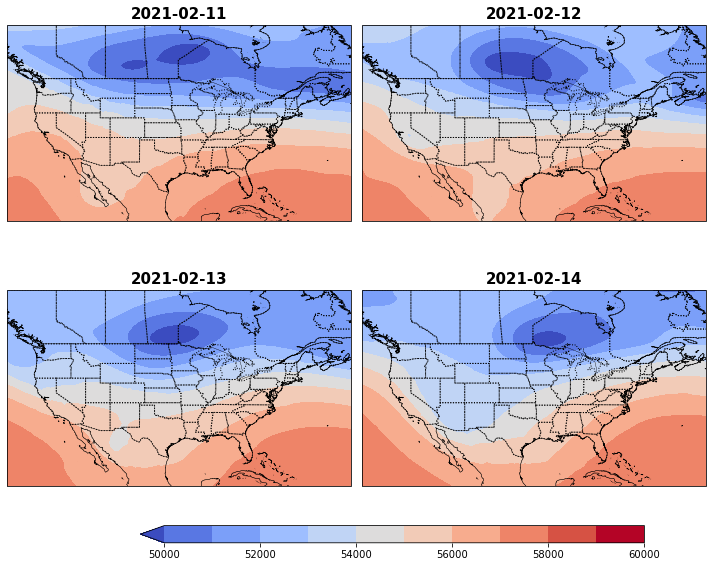

In [344]:
lat_s = 20.
lat_e = 60.
lon_s = -130.
lon_e = -60.

date_1d = pd.date_range("2021-02-11", periods=4)
date_1d

for dd in range(11, 15):
    flnm_era5 = '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/202102/e5.oper.an.pl.128_129_z.ll025sc.202102'+str(dd)+'00_202102'+str(dd)+'23.nc'
    print(flnm_era5)
    with xr.open_dataset(flnm_era5 ) as ds_era5:
        z500 = ds_era5.Z[12].sel(level=500, latitude=slice(lat_e, lat_s), longitude=slice(lon_s+360, lon_e+360)) #.mean(dim='time')
        del z500['time']
        if (dd==11):
            #expand_dims() modifies ndarray flags to write only, 
            #  to call .copy() on the array after calling expand_dims()
            z500_3d = z500.expand_dims({'time':date_1d}).copy()
                       
        z500_3d[dd-11] = z500         
       
fig = plt.figure(figsize=(10,8))       
       
plot_prec_4(z500_3d, 50000, 60000,  'coolwarm', 'horizontal', 'False') ## 'YlGnBu')
